Adapted from : https://www.kaggle.com/code/theoviel/dicom-resized-png-jpg

**Dataset Links :**
- Part 1 : https://www.kaggle.com/datasets/theoviel/rsna-abdominal-trauma-detection-png-pt1
- Part 2 : https://www.kaggle.com/datasets/theoviel/rsna-abdominal-trauma-detection-png-pt2
- Part 3 : https://www.kaggle.com/datasets/theoviel/rsna-2023-abdominal-trauma-detection-pngs-3-8
- Part 4 : https://www.kaggle.com/datasets/theoviel/rsna-abdominal-trauma-detection-png-pt4
- Part 5 : https://www.kaggle.com/datasets/theoviel/rsna-abdominal-trauma-detection-png-pt5
- Part 6 : https://www.kaggle.com/datasets/theoviel/rsna-abdominal-trauma-detection-png-pt6
- Part 7 : https://www.kaggle.com/datasets/theoviel/rsna-abdominal-trauma-detection-pngs-pt7
- Part 8 : https://www.kaggle.com/datasets/theoviel/rsna-2023-abdominal-trauma-detection-pngs-18

**Changes :**
- Apply `standardize_pixel_array` function
- Update links

**TODO :**
- Dicom processing on GPU
- Figure out why example dicom is too dark

In [40]:
#!pip install -qU python-gdcm pydicom pylibjpeg
#!pip install opencv-python
#!pip install seaborn

In [41]:
import os
import cv2
import glob
import gdcm
import pydicom
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut
from multiprocessing import Pool

In [42]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array

In [43]:
TRAIN_PATH = "/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection/train_images/"

print('Number of training patients :', len(os.listdir(TRAIN_PATH)))

Number of training patients : 3147


10127
53380


(512, 512)


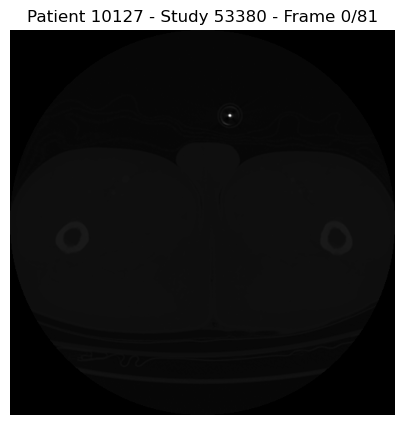

10127
1554
(512, 512)


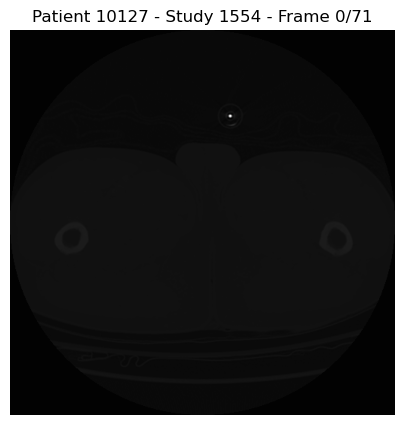

In [44]:
counter = 0
for patient in sorted(os.listdir(TRAIN_PATH)):
    for study in os.listdir(TRAIN_PATH + patient):
        counter+=1
        if(counter < 15):
            continue
        if(counter > 16):
            break
        print(patient)
        print(study)
        imgs = {}
        for f in sorted(glob.glob(TRAIN_PATH + f"{patient}/{study}/*.dcm"))[::10]:
            dicom = pydicom.dcmread(f)

            pos_z = dicom[(0x20, 0x32)].value[-1]  # to retrieve the order of frames

            img = standardize_pixel_array(dicom)
            
            #img = (img - img.min()) / (img.max() - img.min() + 1e-6)
            #junseonglee11 it seems there are some outliers that make img max very big --> quantile?
            quant_0_95 = np.quantile(img, 0.8)
            quant_0_05 = np.quantile(img, 0.2)
            img = (img - quant_0_05) / (quant_0_95 - quant_0_05 + 1e-6)
            
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img

            imgs[pos_z] = img
        print(np.shape(img))
        for i, k in enumerate(sorted(imgs.keys())):
            img = imgs[k]
            
            if not (i % 100):
                plt.figure(figsize=(5, 5))
                plt.imshow(img, cmap="gray")
                plt.title(f"Patient {patient} - Study {study} - Frame {i}/{len(imgs)}")
                plt.axis(False)
                plt.show()
    
        #break
    #break

### Save the processed data

In [45]:
def process(patient, size=512, save_folder="", data_path=""):
    for study in sorted(os.listdir(data_path + patient)):
        imgs = {}
        for f in sorted(glob.glob(data_path + f"{patient}/{study}/*.dcm")):
            dicom = pydicom.dcmread(f)

            pos_z = dicom[(0x20, 0x32)].value[-1]

            img = standardize_pixel_array(dicom)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6)

            if dicom.PhotometricInterpretation == "MONOCHROME1":
                img = 1 - img

            imgs[pos_z] = img

        for i, k in enumerate(sorted(imgs.keys())):
            img = imgs[k]
            if size is not None:
                img = cv2.resize(img, (size, size))

            if isinstance(save_folder, str):
                cv2.imwrite(save_folder + f"{patient}_{study}_{i}.png", (img * 255).astype(np.uint8))
            else:
                im = cv2.imencode('.png', (img * 255).astype(np.uint8))[1]
                save_folder.writestr(f'{patient}_{study}_{i:04d}.png', im)

In [46]:
n_chunk = 8
patients = os.listdir(TRAIN_PATH)
n_patients = len(patients)
rng_patients = np.linspace(0, n_patients+1, n_chunk+1, dtype = int)
rng_patients

array([   0,  262,  524,  787, 1049, 1311, 1574, 1836, 2098, 2361, 2623,
       2885, 3148])

In [51]:
#Use multiprocess to accelerate
def process_chunk(chunk, patients = patients, rng_patients = rng_patients):
    patients = patients[rng_patients[chunk]:rng_patients[chunk+1]]
    with zipfile.ZipFile(f"output_{chunk}.zip", 'w') as save_folder:
        for patient in tqdm(patients):
            process(patient, size=None, save_folder=save_folder, data_path=TRAIN_PATH)

In [50]:
pool = Pool(n_chunk)
pool.map(process_chunk, range(0, n_chunk))

  0%|          | 0/262 [00:00<?, ?it/s]

KeyboardInterrupt: 

  3%|▎         | 8/262 [00:16<09:53,  2.34s/it]

Done ! 